In [1]:
# y -> outlet liquid temperature
# q(t) -> liquid flow rate
# Narx -> yhat(t+1|t) = f(y(t) ... y(t-3) u(t) ... u(t-9))

#read data
data = open('../exchanger/exchanger.dat')
lst = []
for line in data:
    lst += [line.split()]
time = [float(x[0]) for x in lst]
u = [float(x[1]) for x in lst]
y = [float(x[2]) for x in lst]

In [2]:
#divide identification set and validation set
ID_LENGHT = 3000
time_id = time[:ID_LENGHT]
u_id = u[:ID_LENGHT]
y_id = y[:ID_LENGHT]

time_val = time[ID_LENGHT:]
u_val = u[ID_LENGHT:]
y_val = y[ID_LENGHT:]

In [3]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

poly_degree = 2

features = ['u(t)', 'u(t-1)', 'u(t-2)', 'u(t-3)', 'u(t-4)', 'u(t-5)', 'u(t-6)', 'u(t-7)', 'u(t-8)', 'u(t-9)',\
                'y(t)', 'y(t-1)', 'y(t-2)', 'y(t-3)']

poly = PolynomialFeatures(poly_degree)

In [4]:
Y = np.array(y_id[10:len(y_id)])
PHI = []
for i in tqdm(range(ID_LENGHT - 10)):
    regressors = [u_id[i:i+10] + y_id[6+i:10+i]]
    PHI.append(poly.fit_transform(regressors)[0])
PHI = np.array(PHI)
regressor_terms = poly.get_feature_names(features)

100%|████████████████████████████████████████████████████████████████████████████| 2990/2990 [00:02<00:00, 1032.82it/s]


In [5]:
#FROE Implementation

A = np.zeros((PHI.shape[1],PHI.shape[1]))
W = np.zeros(PHI.shape)
g_hat = np.array([])
np.fill_diagonal(A,1)
regressor_selected = np.array([], dtype=int)
err_sum = 0
threshold = 0.000015
    
for k in range(PHI.shape[1]):
    err = np.array([])
    g = np.array([])
    if k == 0:
        for i in range(PHI.shape[1]):
            W[:,0] = PHI[:,i]
            g_i = np.dot(W[:,0],Y)/np.power(np.linalg.norm(W[:,0]),2)
            g = np.append(g, g_i)
            err_i = np.power(g_i,2) *  np.power(np.linalg.norm(W[:,0]),2) / np.power(np.linalg.norm(Y),2)
            err = np.append(err, err_i)
        j = np.argmax(err)
        print(regressor_terms[j])
        W[:,0] = PHI[:,j]
        g_hat = np.append(g_hat, g[j])
        regressor_selected = np.append(regressor_selected, j)
        err_sum += err[j]
        if (1-err_sum < threshold):
            print('Threshold exceeded!')
            break;
    else:
        for l in range(PHI.shape[1]):
            if l not in regressor_selected:
                temp = np.zeros(PHI.shape[0])
                for i in range(k):
                    A[i,k] = (np.dot(W[:,i],PHI[:,l]))/np.power(np.linalg.norm(W[:,i]),2)
                    temp += A[i,k] * W[:,i]
                W[:,k] = PHI[:,l] - temp
                #g = np.append(g, (np.dot(W[:,k],Y))/np.power(np.linalg.norm(W[:,k]),2))
                g_i = np.dot(W[:,k],Y)/np.power(np.linalg.norm(W[:,k]),2)
                g = np.append(g, g_i)
                err_i = np.power(g_i,2) *  np.power(np.linalg.norm(W[:,k]),2) / np.power(np.linalg.norm(Y),2)
                err = np.append(err, err_i)
            else:
                err = np.append(err, 0)
                g = np.append(g, 0)
        j = np.argmax(err)
        temp = np.zeros(PHI.shape[0])
        for i in range(k):
            A[i,k] = (np.dot(W[:,i],PHI[:,j]))/np.power(np.linalg.norm(W[:,i]),2)
            temp += A[i,k] * W[:,i]
        print(regressor_terms[j])
        W[:,k] = PHI[:,j] - temp
        g_hat = np.append(g_hat, g[j])
        regressor_selected = np.append(regressor_selected, j)
        err_sum += err[j]
        if (1-err_sum < threshold):
            print('Threshold exceeded!')
            break;
        
theta = np.zeros(len(g_hat))
for i in reversed(range(len(g_hat))):
    if i == len(g_hat):
        theta[i] = g_hat[i]
    else:
        temp = 0
        for k in range(i+1, len(g_hat)):
            temp += A[i,k] * theta[k]
        theta[i] = g_hat[i] - temp

y(t-3)
u(t-4) u(t-5)
y(t-2)
u(t-7) y(t-3)
u(t-7)
u(t-6) u(t-8)
y(t)
u(t-7) u(t-8)
u(t-7)^2
u(t-6) y(t-3)
u(t-7) u(t-9)
u(t-6)
u(t-5) y(t-3)
u(t-5)
u(t-8)^2
u(t-6)^2
Threshold exceeded!


In [6]:
PHI_final = np.zeros((PHI.shape[0], len(regressor_selected)))
for i in range(len(regressor_selected)):
    PHI_final[:,i] = PHI[:, regressor_selected[i]]

In [7]:
y_hat = np.dot(PHI_final, theta)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Matteo\Anaconda3\envs\py35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['poly']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


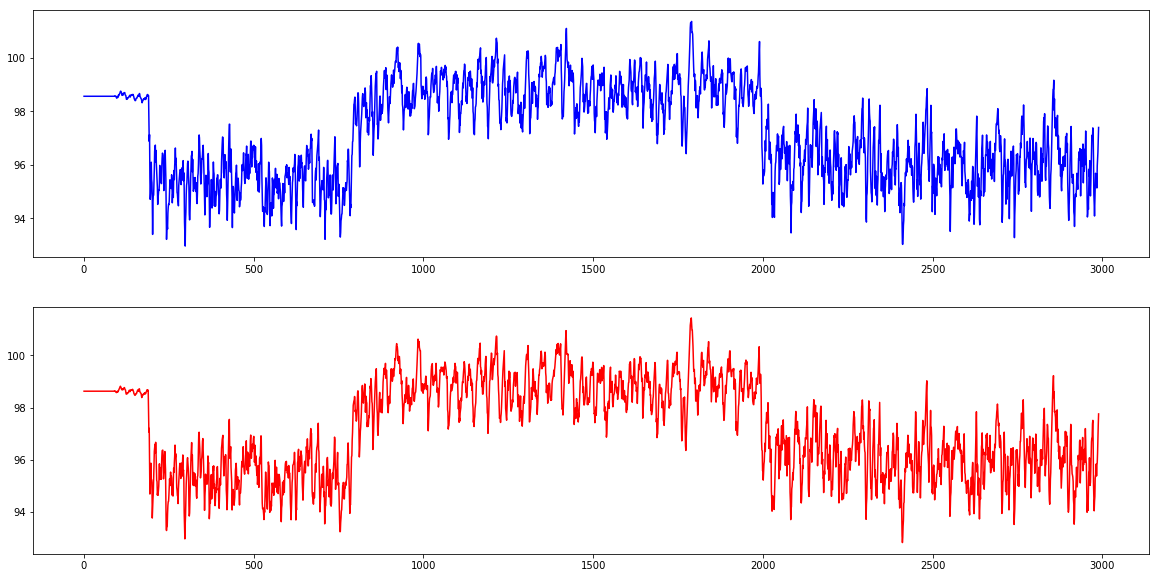

In [8]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

plt.subplot(211)
plt.plot(y_hat[:2990], color='blue')
plt.subplot(212)
plt.plot(y_id[10:3000], color='red')
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error
MSE_id = mean_squared_error(y_id[10:],y_hat)
MSE_id

0.14169891973561285

In [10]:
#Validation
Y_val = np.array(y_val[10:len(y_val)])
PHI_val = []
poly = PolynomialFeatures(poly_degree)
for i in range(1000-10):
    regressors = [u_val[i:i+10] + y_val[6+i:10+i]]
    PHI_val.append(poly.fit_transform(regressors)[0])
PHI_val = np.array(PHI_val)

In [11]:
PHI_final_val = np.zeros((PHI_val.shape[0], len(regressor_selected)))
for i in range(len(regressor_selected)):
    PHI_final_val[:,i] = PHI_val[:, regressor_selected[i]]

In [12]:
y_hat_val = np.dot(PHI_final_val, theta)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Matteo\Anaconda3\envs\py35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['poly']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


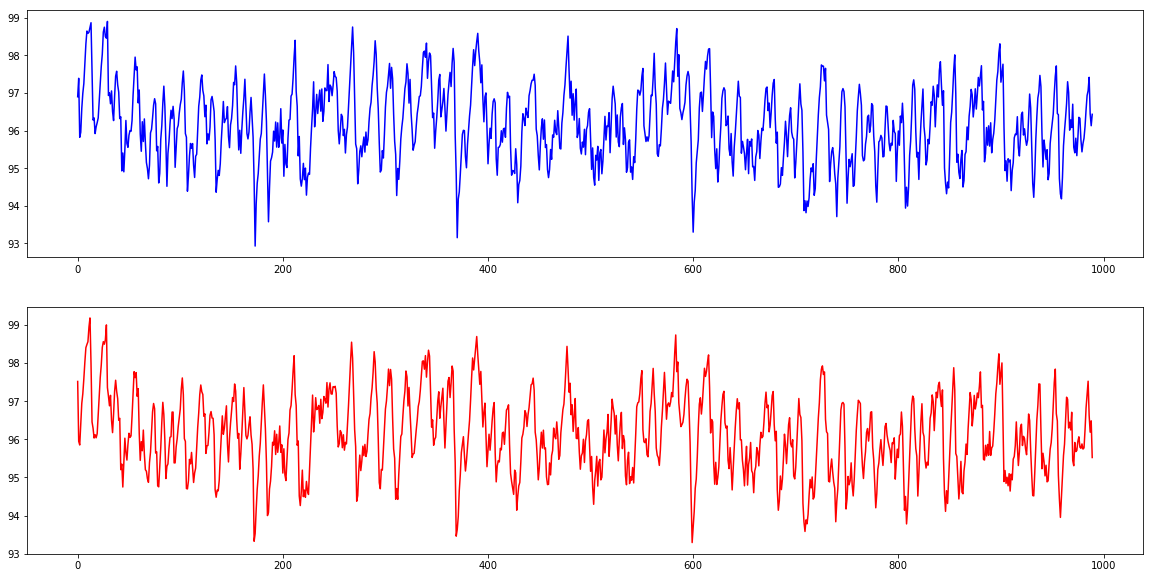

In [13]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

plt.subplot(211)
plt.plot(y_hat_val[:990], color='blue')
plt.subplot(212)
plt.plot(y_val[10:1000], color='red')
plt.show()

In [14]:
MSE_val = mean_squared_error(y_val[10:],y_hat_val)
MSE_val

0.22330111180739523

In [15]:
## Simulation 
# start from initial phi, then build step by step each ne element
poly = PolynomialFeatures(poly_degree)
reg_y = y_val[6:10]
reg = [u_val[:10] + y_val[6:10]]
reg = poly.fit_transform(reg)[0]
len(reg)

120

In [16]:
model_reg = reg[regressor_selected]  # initial values for the regression

In [17]:
#simulate the process
y_hat_sim  = []
for i in range(1000-10):
    y_i = np.dot(model_reg,theta) #simulated
    y_hat_sim.append(y_i)
    reg_u = u_val[i+1:i+1+10]
    reg_y = (reg_y + [y_i])[1:] #append at beggining, then remove last one( [:-1])
    reg = [ reg_u + reg_y]
    reg = poly.fit_transform(reg)[0]
    model_reg = reg[regressor_selected]

Populating the interactive namespace from numpy and matplotlib


C:\Users\Matteo\Anaconda3\envs\py35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['poly']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


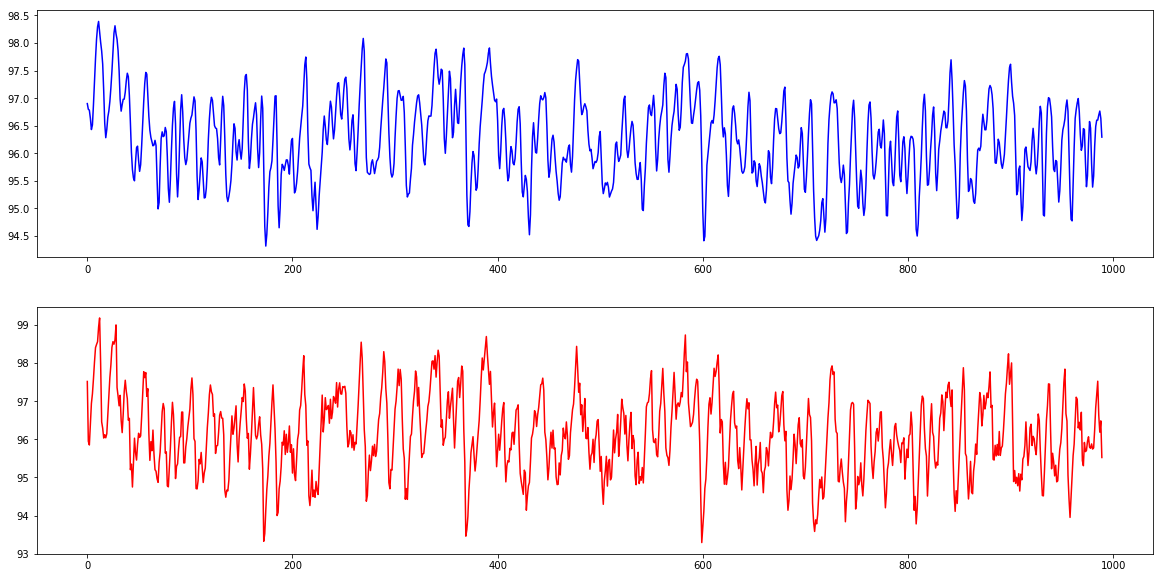

In [18]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

plt.subplot(211)
plt.plot(y_hat_sim[:990], color='blue')
plt.subplot(212)
plt.plot(y_val[10:1000], color='red')
plt.show()

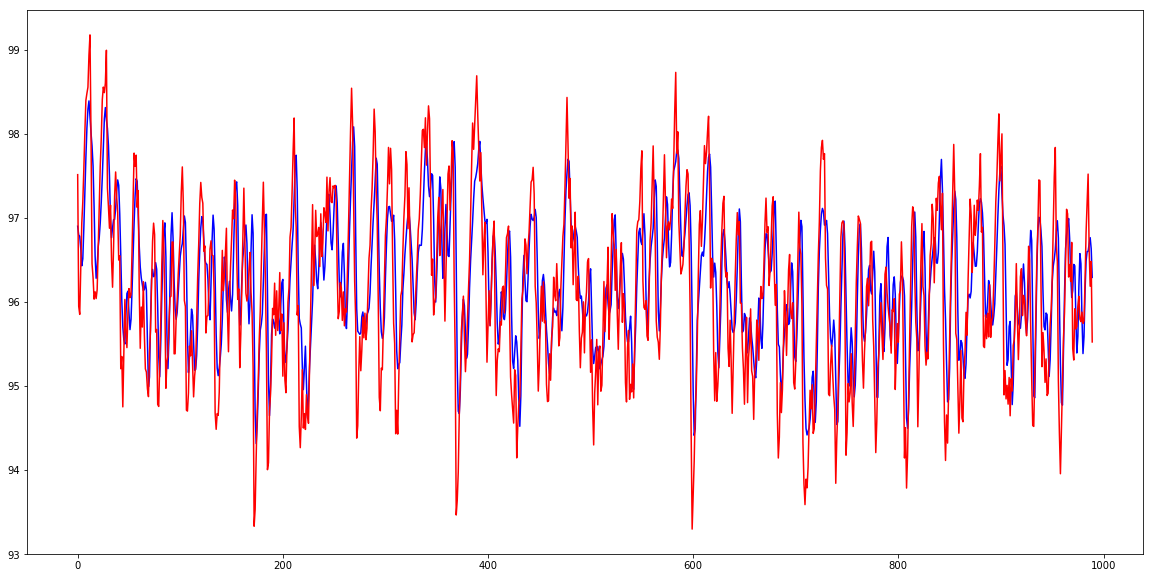

In [20]:
plt.plot(y_hat_sim[:990], color='blue')
plt.plot(y_val[10:1000], color='red')
plt.show()

In [ ]:
MSE_sim = mean_squared_error(y_val[10:],y_hat_sim)
MSE_sim